In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [382]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['disease'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('disease', axis=1)
    y = data['disease']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns


In [383]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, feature_mask=None):
        self.k = k
        self.feature_mask = feature_mask

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_[i] for i in k_indices]
        return np.argmax(np.bincount(k_nearest_labels))

In [384]:
def cross_validate(X, y, k, feature_mask, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_scores = []
    precisions = []
    recalls = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = kNN(k=k, feature_mask=feature_mask)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        
        # print(f"Fold - Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")
    
    return f1_scores, precisions, recalls

In [385]:
def feature_importance(X, y):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    importances = dt.feature_importances_
    return pd.Series(importances).sort_values(ascending=False)

importance_results = feature_importance(X, y)

print(importance_results)

12    0.279725
2     0.151193
11    0.108062
7     0.083773
4     0.079608
9     0.076073
0     0.072169
3     0.050094
10    0.031960
1     0.028341
6     0.016259
8     0.012420
5     0.010323
dtype: float64


In [386]:
def elbow(X, y, k_range):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scores = []
    for k in k_range:
        knn = kNN(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        scores.append((precision, recall, f1))

    precisions, recalls, f1_scores = zip(*scores)

    plt.plot(k_range, f1_scores)
    plt.xlabel('k')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

    optimal_k = k_range[np.argmax(f1_scores)]
    
    return optimal_k, f1_scores

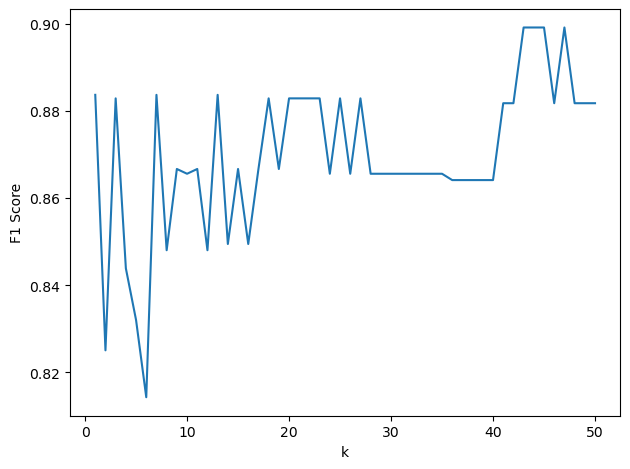

Optimal k value: 43
Best F1 Score: 0.899


In [387]:
k_range = range(1, 51)
optimal_k, f1_scores = elbow(X, y, k_range)
print(f"Optimal k value: {optimal_k}")
print(f"Best F1 Score: {max(f1_scores):.3f}")

In [388]:
# Load the data
X, y, feature_names = load_data('data/cleveland.csv')

# Manually select features and k
selected_features = ['age', 'sex', 'cp', 'trestbps', 'chol']
k = 5

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['age', 'sex', 'cp', 'trestbps', 'chol']
k value: 5

Cross-validation results:
Fold 1:
  Precision: 0.556
  Recall: 0.455
  F1 Score: 0.500
Fold 2:
  Precision: 0.733
  Recall: 0.846
  F1 Score: 0.786
Fold 3:
  Precision: 0.929
  Recall: 0.765
  F1 Score: 0.839
Fold 4:
  Precision: 0.857
  Recall: 0.667
  F1 Score: 0.750
Fold 5:
  Precision: 0.765
  Recall: 0.650
  F1 Score: 0.703
Fold 6:
  Precision: 0.615
  Recall: 0.615
  F1 Score: 0.615
Fold 7:
  Precision: 0.533
  Recall: 0.667
  F1 Score: 0.593
Fold 8:
  Precision: 0.625
  Recall: 0.769
  F1 Score: 0.690
Fold 9:
  Precision: 0.769
  Recall: 0.909
  F1 Score: 0.833
Fold 10:
  Precision: 0.500
  Recall: 0.667
  F1 Score: 0.571

Mean scores:
Precision: 0.688 (+/- 0.137)
Recall: 0.701 (+/- 0.121)
F1 Score: 0.688 (+/- 0.110)


kNN(feature_mask=array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False]),
    k=5)

In [389]:
# Function to predict on challenge dataset
def predict_challenge(challenge_file, model):
    X_challenge, y_challenge, _ = load_data(challenge_file)
    y_pred = model.predict(X_challenge)
    return f1_score(y_challenge, y_pred)

# Predict on the sample test dataset
challenge_f1 = predict_challenge('data/cleveland-test-sample.csv', final_model)
print(f"\nF1 Score on challenge dataset: {challenge_f1:.3f}")


F1 Score on challenge dataset: 0.833
